In [48]:
#Import statements
%matplotlib inline
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from copy import deepcopy
import math
from matplotlib import gridspec
from PIL import Image
import pandas as pd
import random
import itertools
from scipy import interp
import matplotlib.cm as cm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.metrics import *
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.utils import resample
import matplotlib.patheffects as PathEffects
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.patches import Ellipse
import scipy.stats
import matplotlib as mpl
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

In [49]:
def cm_heatmap(CM, classes, title=''):
    fig, ax = plt.subplots(figsize=(11,8))
    im = ax.imshow(CM)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    ax.set_title("Confusion Matrix" + title)
    fig.tight_layout()
    plt.colorbar(im, shrink=0.5)
    plt.show()
"""
This function prints and plots the confusion matrix.
Normalization can be applied by setting `normalize=True`.
Adapted from code at: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
"""
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    bottom, top = plt.ylim() 
    plt.ylim(bottom, top)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    

def bench_cluster(estimator, name, data):
    estimator.fit(data)
    if name == 'GMM':
        labels_ = gmm.fit(data).predict(data)
    else:
        labels_ = estimator.labels_
    hg = metrics.homogeneity_score(labels, labels_)
    cmpl = metrics.completeness_score(labels, labels_)
    vmes = metrics.v_measure_score(labels, labels_)
    adjr = metrics.adjusted_rand_score(labels, labels_)
    adjm = metrics.adjusted_mutual_info_score(labels,  labels_)
    sil = metrics.silhouette_score(data, labels_, metric='euclidean', sample_size=sample_size)
    a = {'Results': [hg, cmpl, vmes, adjr, adjm, sil]}#series of evaluation results
    aFrame_kmeans = pd.DataFrame(a, index = ['Homogeneity', 'Completeness', 'V-measure', 'Adjusted Rand index (ARI)', 'Adjusted Mutual Information (AMI)', 'Silhouette'])
    print(aFrame_kmeans)#print series of evaluation metrics

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, classes, label=True, ax=None, draw_ellipse=False):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='jet', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    centers = np.empty(shape=(gmm.n_components, X.shape[1]))
    for i in range(gmm.n_components):
        density = scipy.stats.multivariate_normal(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(X)
        centers[i, :] = X[np.argmax(density)]
    for i in range(centers.shape[0]):
        txt = plt.text(centers[i, 0], centers[i, 1], str(classes[i]), horizontalalignment='center',
        verticalalignment='center', color="white", fontsize=14)
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='black')])
    
    if draw_ellipse:
        w_factor = 0.2 / gmm.weights_.max()
        for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
            draw_ellipse(pos, covar, alpha=w * w_factor)
        

In [50]:
#cropped image flattening and data matrix concatenation
parent_dir = "/Users/danielburnham/Documents/AMATH Masters/AMATH563/HW3/CroppedYale/"
gender_labels = pd.read_csv('CroppedYale_genderClass.txt', sep=" ", header=None)#pull in gender label assumptions from text file
gender_labels.columns = ["face_id", "gender_label"]#label columns of dataframe containing gender labels by face id
cropped_faces = []#list to hold face image data
face_labels = []#list to hold face ids for each image
gender_class = []#list to hold assumed gender labels for each image
for subdir, dirs, files in os.walk(parent_dir):
    for d in dirs:
        abs_path = os.path.join(parent_dir, d)
        face_id = d.split('yale')[1]
        gender_label = gender_labels.loc[gender_labels['face_id'] == face_id]['gender_label'].item()
        for subdir, dirs, files in os.walk(parent_dir + d + "/"):
            for file in files:
                im_path = os.path.join(abs_path, file)
                face = cv2.imread(im_path, -1)
                cropped_faces.append(face)
                face_labels.append(face_id)
                gender_class.append(gender_label)
flat_faces = []
for i in range(0, len(cropped_faces)):
    flat_face = cropped_faces[i].flatten()
    flat_faces.append(flat_face)
cropped_data = np.transpose(np.array(flat_faces))

Text(0.5, 0, 'Mode')

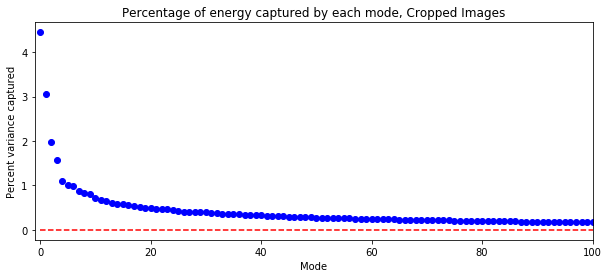

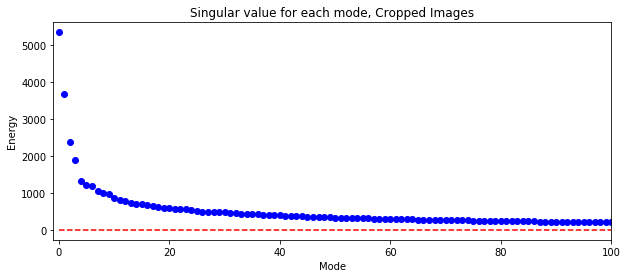

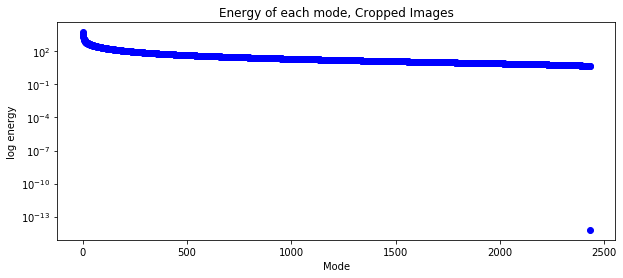

In [51]:
#Apply SVD to cropped faces data
pix, fac = cropped_data.shape#pix = pixels, fac = faces

X = preprocessing.scale(cropped_data)#standardize the data
#Compute SVD
U, Sigma, VT = np.linalg.svd(X, full_matrices=False)

#Plot percentage of variance captured by differnt modes
#Principle component oscillations
f, ax1 = plt.subplots(1, 1, figsize=(10, 4))
ax1.plot((Sigma / sum(Sigma)) * 100, 'bo')
ax1.plot(np.arange(len(Sigma)), np.zeros(len(Sigma)), 'r--');
ax1.set_title('Percentage of energy captured by each mode, Cropped Images')
ax1.set_ylabel('Percent variance captured')
ax1.set_xlabel('Mode')
ax1.set_xlim(( -1, 100))

f, ax1 = plt.subplots(1, 1, figsize=(10, 4))
ax1.plot(Sigma, 'bo')
ax1.plot(np.arange(len(Sigma)), np.zeros(len(Sigma)), 'r--');
ax1.set_title('Singular value for each mode, Cropped Images')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Mode')
ax1.set_xlim(( -1, 100))

f, ax1 = plt.subplots(1, 1, figsize=(10, 4))
ax1.semilogy(np.arange(1, fac + 1), Sigma, 'bo')
ax1.set_title('Energy of each mode, Cropped Images')
ax1.set_ylabel('log energy')
ax1.set_xlabel('Mode')
#ax1.set_xlim(( -0.5, 25))
#ax1.set_ylim((10**-3, 10**1))

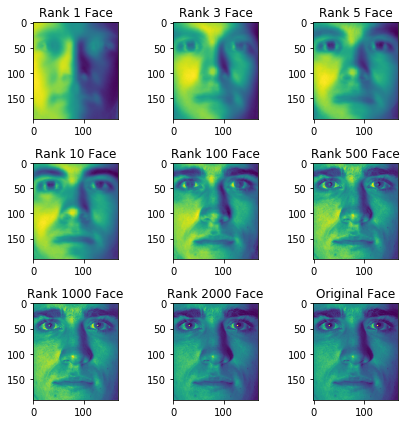

In [65]:
#Project onto the left singular vectors, compare reconstructed images to originals
'''
Deductions:
* (-0.25 points) Your interpretation of the SVD is slightly off for the Yale Faces. 
U contains the eigenface basis, Sigma contains the singular values (information about 
the rank of the data set), and V contains the coefficients needed to reconstruct each face 
using the eigenface basis. 
* (-0.5 points) Your faces in Figures 2(d) and 3(d) are faces in the eigenface basis, 
not low-rank reconstructions of any particular face.
'''
ranks = [1, 3, 5, 10, 100, 500, 1000, 2000]
image = 5

cols = 3
rows = int(math.ceil((len(ranks) + 1) / cols))

gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize=(2*rows, 2*cols))
for i in range(0, len(ranks) + 1):
    ax = fig.add_subplot(gs[i])
    #if loop has gone through all desired ranks, lastly plot the original image
    if i == len(ranks):
        X_r_reshape = X[:, image].reshape(cropped_faces[image].shape)#set the X_r_reshape to be original image for plotting
        ax.set_title('Original Face')
    else:
        #get low rank approximation of data matrix
        X_r = U[:, :ranks[i]] @ np.diag(Sigma[:ranks[i]]) @ VT[:ranks[i], :]
        X_r_reshape = (X_r[:, image]).reshape(cropped_faces[image].shape)
        ax.set_title('Rank ' + str(ranks[i]) + ' Face')
    
    ax.imshow(X_r_reshape)
fig.tight_layout()

In [66]:
#uncropped image flattening and data matrix concatenation
parent_dir = "/Users/danielburnham/Documents/AMATH Masters/AMATH563/HW3/yalefaces_uncropped/"
uncropped_faces = []
for subdir, dirs, files in os.walk(parent_dir):
    for d in dirs:
        abs_path = os.path.join(parent_dir, d)
        for subdir, dirs, files in os.walk(parent_dir + d + "/"):
            for file in files:
                im_path = os.path.join(abs_path, file)
                gif = cv2.VideoCapture(im_path)
                ret,frame = gif.read() # ret=True if it finds a frame else False. Since your gif contains only one frame, the next read() will give you ret=False
                image = Image.fromarray(frame)
                face = grayConversion(np.array(image))
                uncropped_faces.append(face)
flat_faces = []
for i in range(0, len(uncropped_faces)):
    flat_face = uncropped_faces[i].flatten()
    flat_faces.append(flat_face)
uncropped_data = np.transpose(np.array(flat_faces))

Text(0.5, 0, 'Mode')

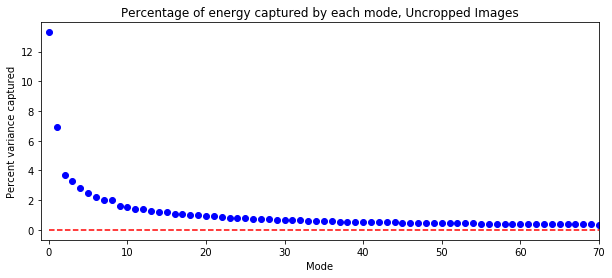

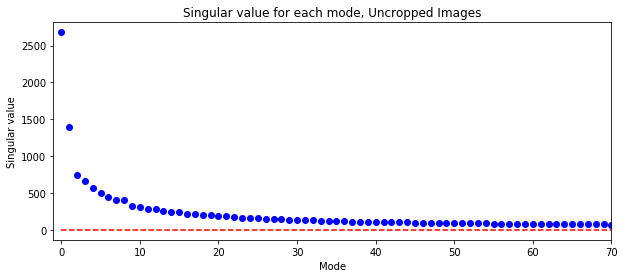

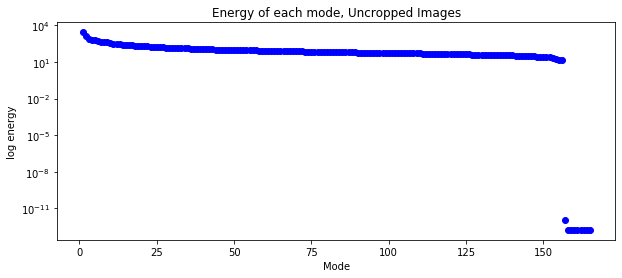

In [67]:
#Apply SVD to cropped faces data
pix, fac = uncropped_data.shape#pix = pixels, fac = faces

Xuc = preprocessing.scale(uncropped_data)#standardize the data

#Compute SVD
U_uc, Sigma_uc, VT_uc = np.linalg.svd(Xuc, full_matrices=False)

#Plot percentage of variance captured by differnt modes
#Principle component oscillations
f, ax1 = plt.subplots(1, 1, figsize=(10, 4))
ax1.plot((Sigma_uc / sum(Sigma_uc)) * 100, 'bo')
ax1.plot(np.arange(len(Sigma_uc)), np.zeros(len(Sigma_uc)), 'r--')
ax1.set_title('Percentage of energy captured by each mode, Uncropped Images')
ax1.set_ylabel('Percent variance captured')
ax1.set_xlabel('Mode')
ax1.set_xlim(( -1, 70))

f, ax1 = plt.subplots(1, 1, figsize=(10, 4))
ax1.plot(Sigma_uc, 'bo')
ax1.plot(np.arange(len(Sigma_uc)), np.zeros(len(Sigma_uc)), 'r--')
ax1.set_title('Singular value for each mode, Uncropped Images')
ax1.set_ylabel('Singular value')
ax1.set_xlabel('Mode')
ax1.set_xlim(( -1, 70))

f, ax1 = plt.subplots(1, 1, figsize=(10, 4))
ax1.semilogy(np.arange(1, fac + 1), Sigma_uc, 'bo')
ax1.set_title('Energy of each mode, Uncropped Images')
ax1.set_ylabel('log energy')
ax1.set_xlabel('Mode')
#ax1.set_xlim(( -0.5, 25))
#ax1.set_ylim((10**-3, 10**1))

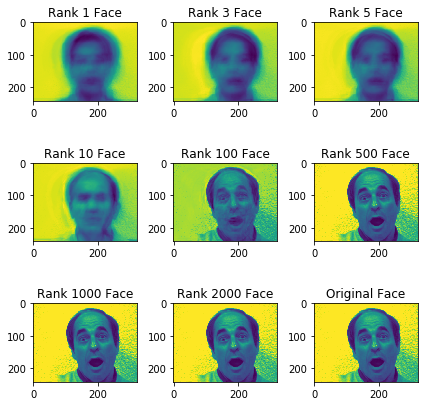

In [68]:
#Project onto the left singular vectors, compare reconstructed images to originals
ranks = [1, 3, 5, 10, 100, 500, 1000, 2000]
image = 5

cols = 3
rows = int(math.ceil((len(ranks) + 1) / cols))
gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize=(2*rows, 2*cols))
for i in range(0, len(ranks) + 1):
    ax = fig.add_subplot(gs[i])
    #if loop has gone through all desired ranks, lastly plot the original image
    if i == len(ranks):
        X_r_reshape = (Xuc[:, image]/np.sqrt(fac - 1)).reshape(uncropped_faces[image].shape)#set the X_r_reshape to be original image for plotting
        ax.set_title('Original Face')
    else:
        X_r = U_uc[:, :ranks[i]] @ np.diag(Sigma_uc[:ranks[i]]) @ VT_uc[:ranks[i], :]
        X_r_reshape = (X_r[:, image]).reshape(uncropped_faces[image].shape)
        ax.set_title('Rank ' + str(ranks[i]) + ' Face')
    
    ax.imshow(X_r_reshape)
fig.tight_layout()

In [30]:
#individual face classification
#train test split
ranks = [10, 50, 100]#ranks of data matrix to build classifiers for
data_mats = {}#dictionary to hold data matrices of different ranks
split_mats = {}#dictionary to hold train and test splits of various data matrices
y_ids = np.array(face_labels)#individual face ids for classification
#cast face ids to integer class labels
y_ids_ints = []
for entry in y_ids:
    num = int(entry.split("B")[1])
    y_ids_ints.append(num)
y_ids_ints = np.array(y_ids_ints)

classes = np.unique(y_ids_ints)#list of unique face ids
for r in ranks:
    X_r = U[:, :r] @ np.diag(Sigma[:r]) @ VT[:r, :]#get low rank approximations of data matrix
    data_mats[str(r)] = X_r
    X_train, X_test, y_train, y_test = train_test_split(np.transpose(X_r), y_ids_ints, test_size = 0.1, random_state=1)
    split_mats['X_train_' + str(r)] = X_train
    split_mats['X_test_' + str(r)] = X_test
    split_mats['y_train_' + str(r)] = y_train
    split_mats['y_test_' + str(r)] = y_test

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))





K Nearest Neighbors Classifier



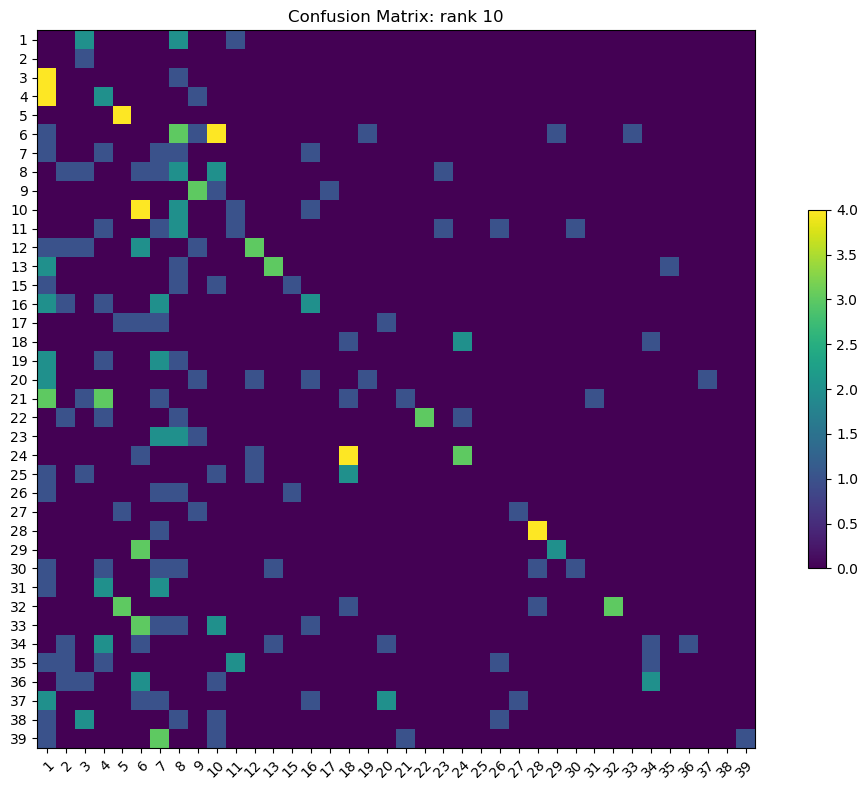

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


            Results   Average       Std
Accuracy   0.176230  0.202449  0.020450
Precision  0.269004  0.313798  0.042107
Recall     0.176230  0.202449  0.020450
F1         0.186364  0.218037  0.022606



Naive Bayes Classifier



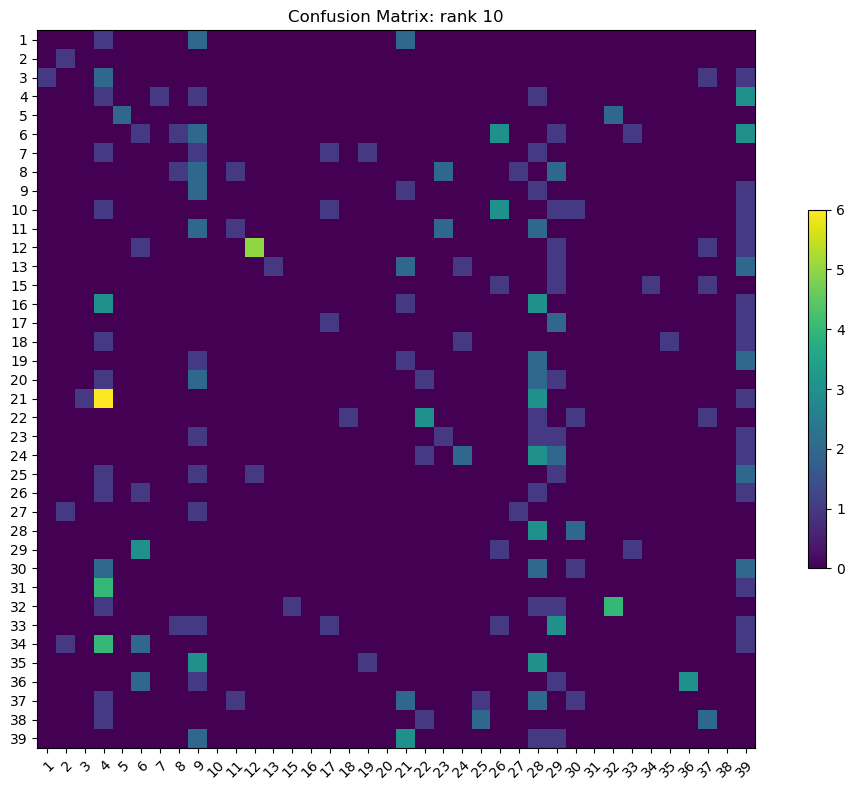

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


            Results   Average       Std
Accuracy   0.139344  0.193304  0.021558
Precision  0.212186  0.308701  0.038860
Recall     0.139344  0.193304  0.021558
F1         0.146826  0.200973  0.023494



Linear Discriminant Analysis Classifier



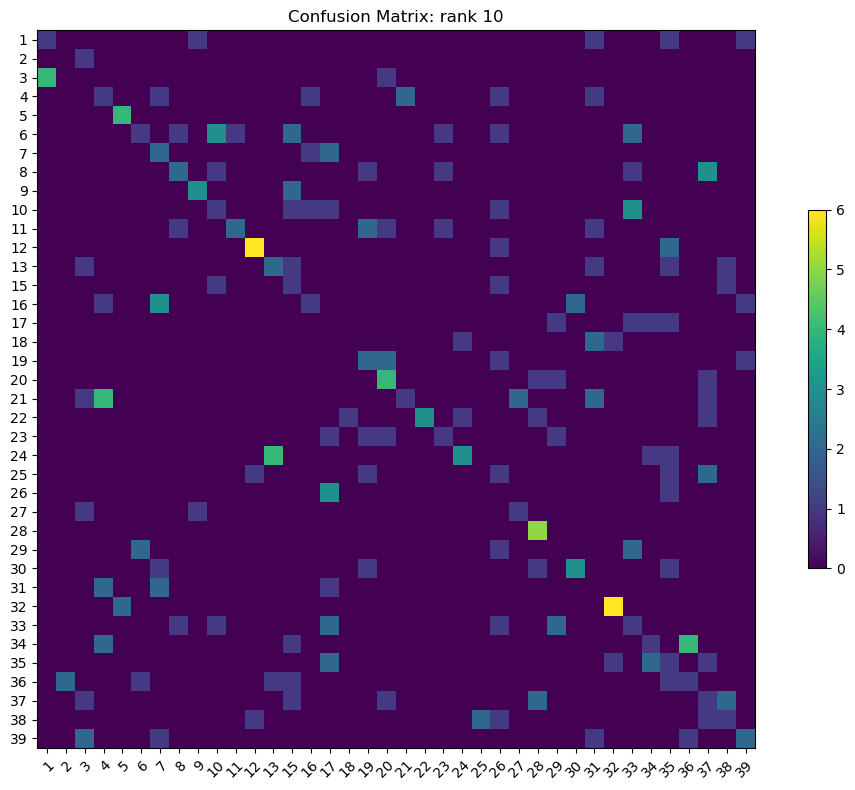

            Results   Average       Std
Accuracy   0.262295  0.338207  0.013366
Precision  0.314917  0.372363  0.017357
Recall     0.262295  0.338207  0.013366
F1         0.268377  0.335908  0.011737



Support Vector Machine Classifier



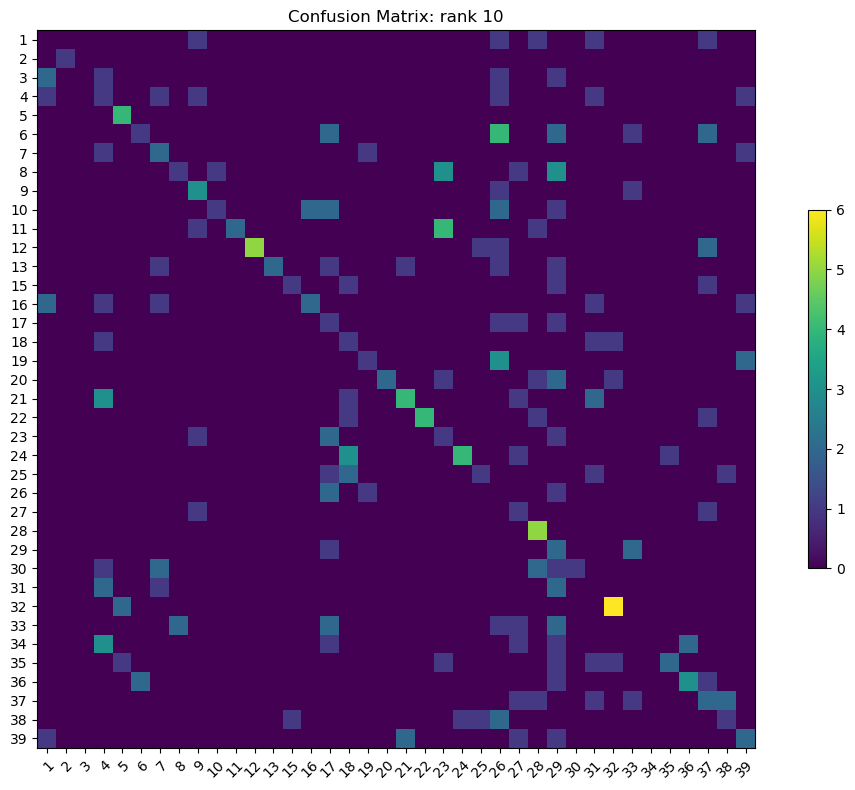

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


            Results   Average       Std
Accuracy   0.286885  0.313978  0.008697
Precision  0.449093  0.452264  0.030744
Recall     0.286885  0.313978  0.008697
F1         0.308009  0.318467  0.012042



Decision Tree Classifier



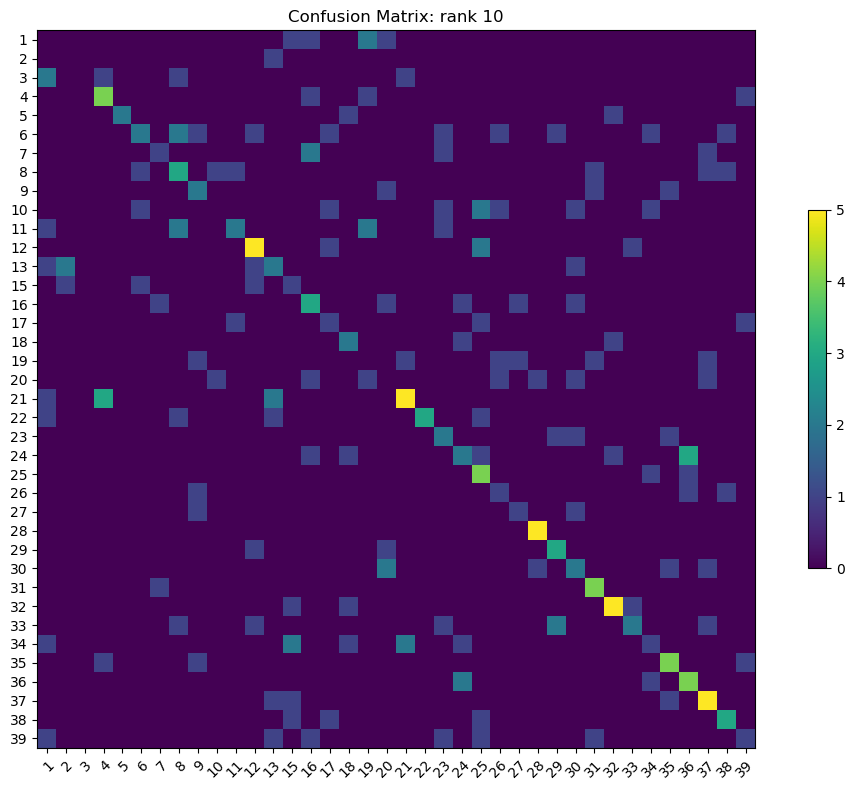

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


            Results   Average       Std
Accuracy   0.356557  0.383925  0.031742
Precision  0.365580  0.414585  0.027672
Recall     0.356557  0.383925  0.031742
F1         0.344385  0.385223  0.027790
Progress 80.0%


K Nearest Neighbors Classifier



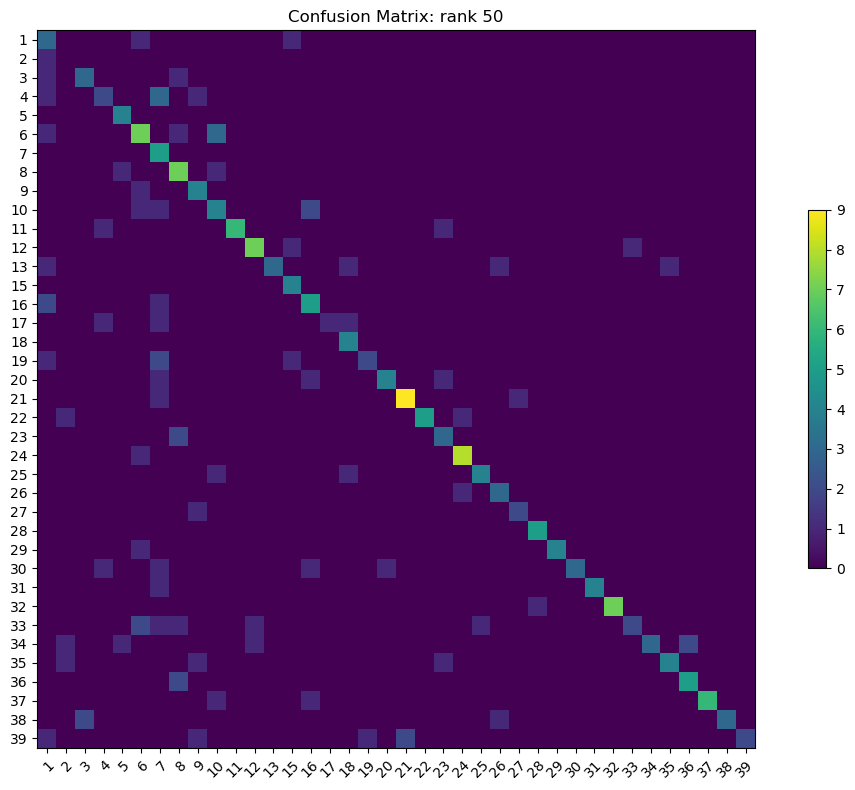

            Results   Average       Std
Accuracy   0.643443  0.644437  0.020848
Precision  0.739660  0.735688  0.025636
Recall     0.643443  0.644437  0.020848
F1         0.649491  0.657720  0.019592



Naive Bayes Classifier



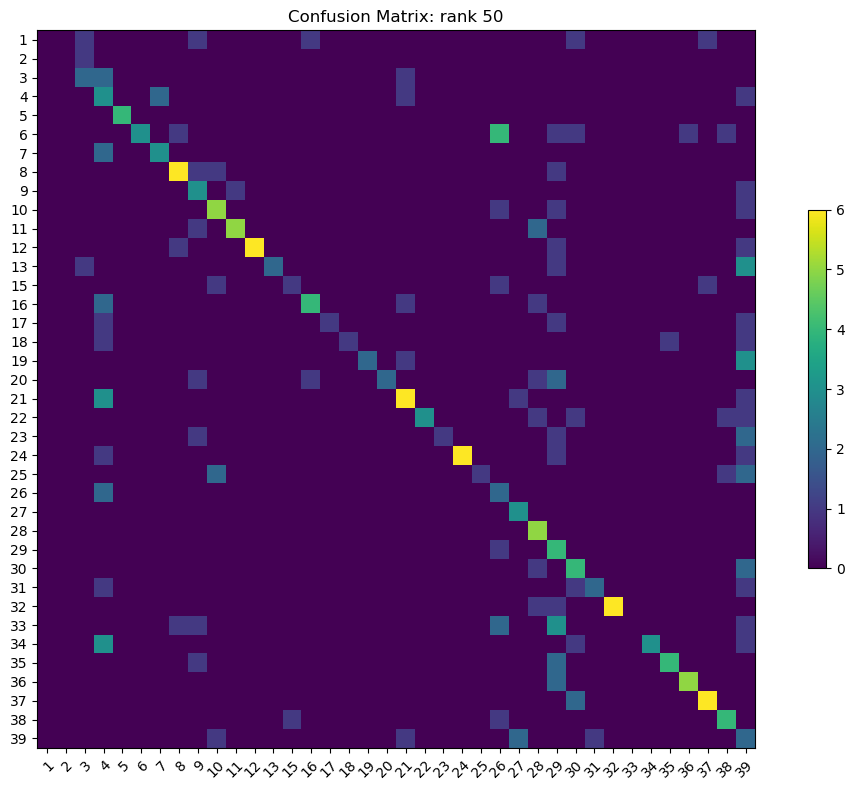

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


            Results   Average       Std
Accuracy   0.491803  0.524707  0.027421
Precision  0.680075  0.663372  0.017899
Recall     0.491803  0.524707  0.027421
F1         0.510710  0.547730  0.025242



Linear Discriminant Analysis Classifier



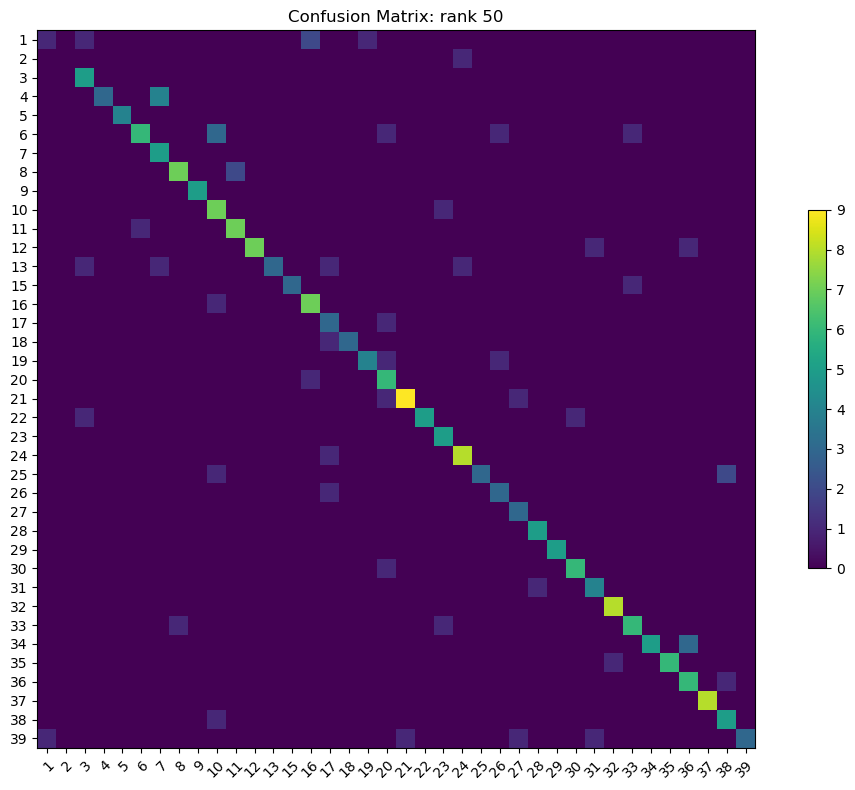

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


            Results   Average       Std
Accuracy   0.774590  0.774702  0.033563
Precision  0.820412  0.833561  0.023703
Recall     0.774590  0.774702  0.033563
F1         0.769527  0.780464  0.033446



Support Vector Machine Classifier



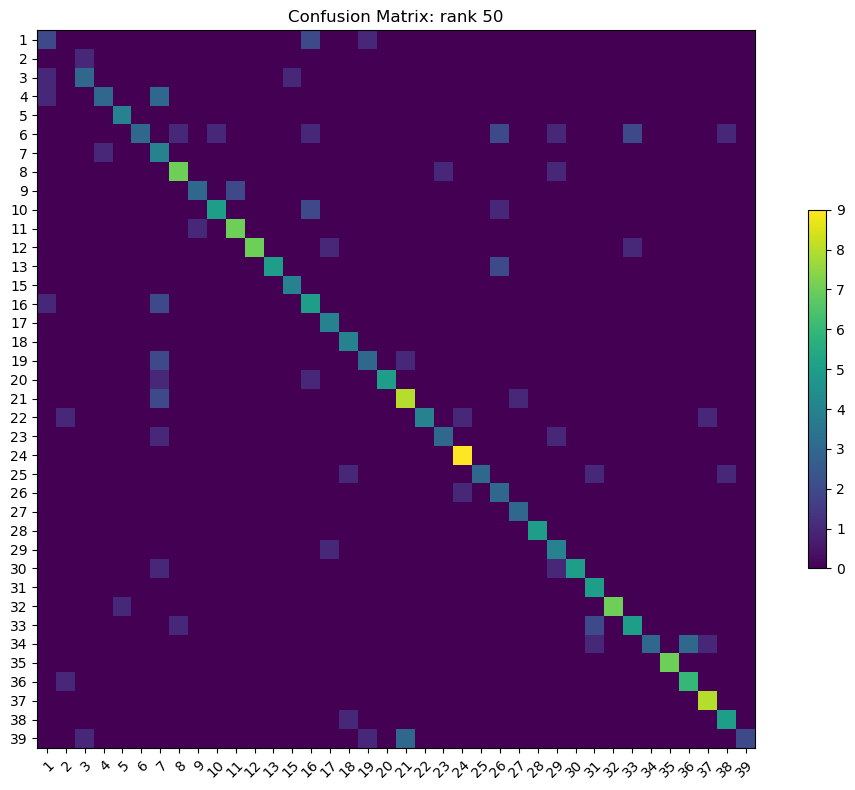

            Results   Average       Std
Accuracy   0.709016  0.755039  0.017495
Precision  0.786622  0.814328  0.016326
Recall     0.709016  0.755039  0.017495
F1         0.708370  0.759946  0.016177



Decision Tree Classifier



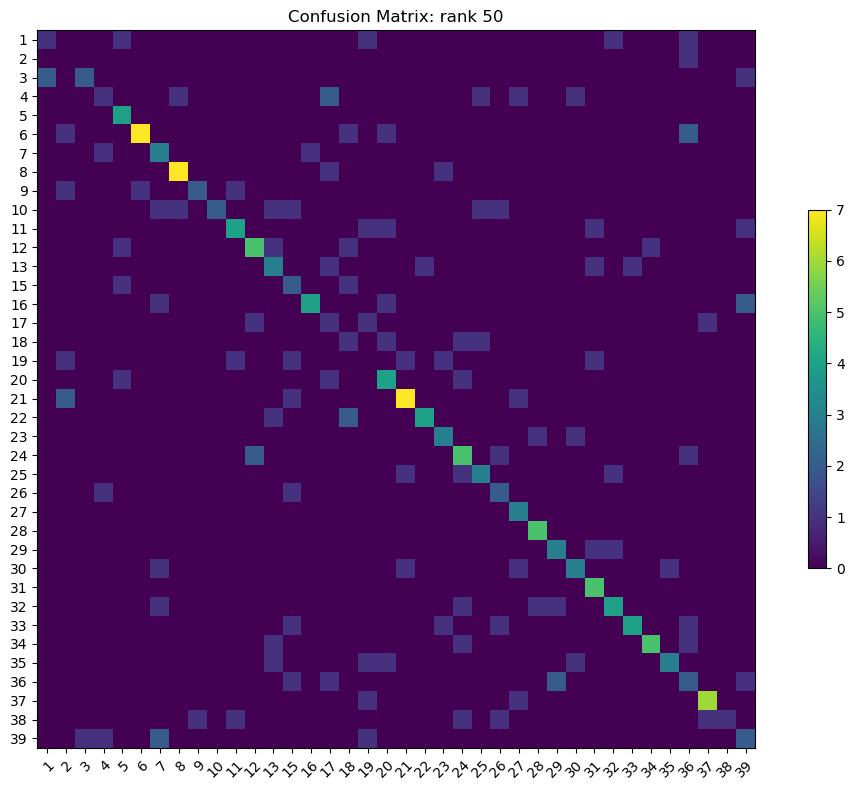

            Results   Average       Std
Accuracy   0.504098  0.522834  0.024622
Precision  0.574276  0.552282  0.024485
Recall     0.504098  0.522834  0.024622
F1         0.508552  0.524648  0.022819
Progress 80.0%


K Nearest Neighbors Classifier



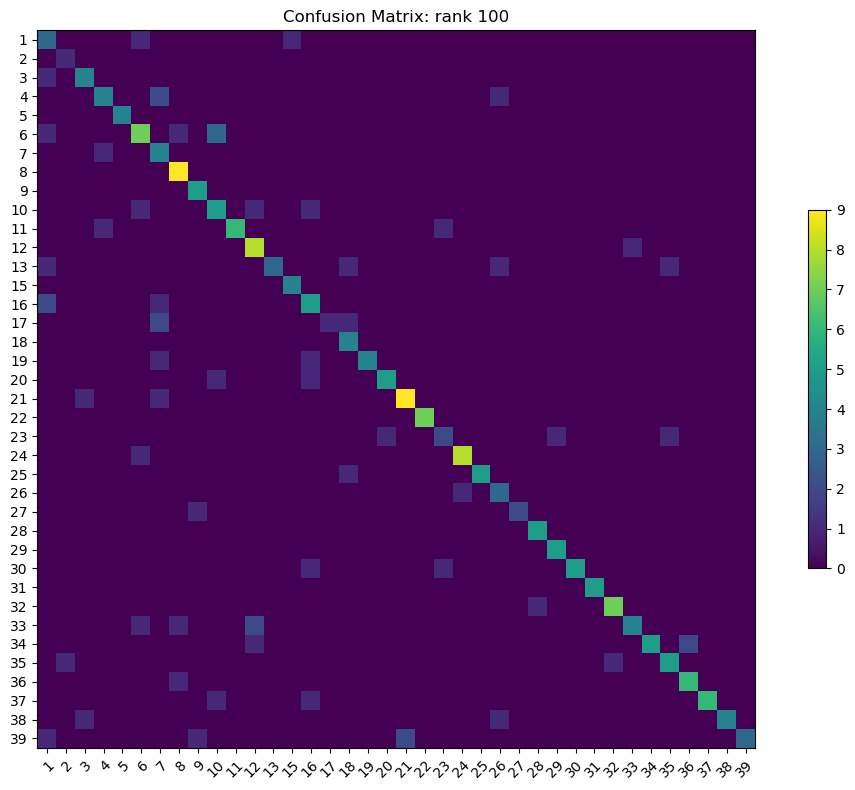

            Results   Average       Std
Accuracy   0.745902  0.740414  0.015207
Precision  0.798135  0.802674  0.017548
Recall     0.745902  0.740414  0.015207
F1         0.747649  0.749133  0.015549



Naive Bayes Classifier



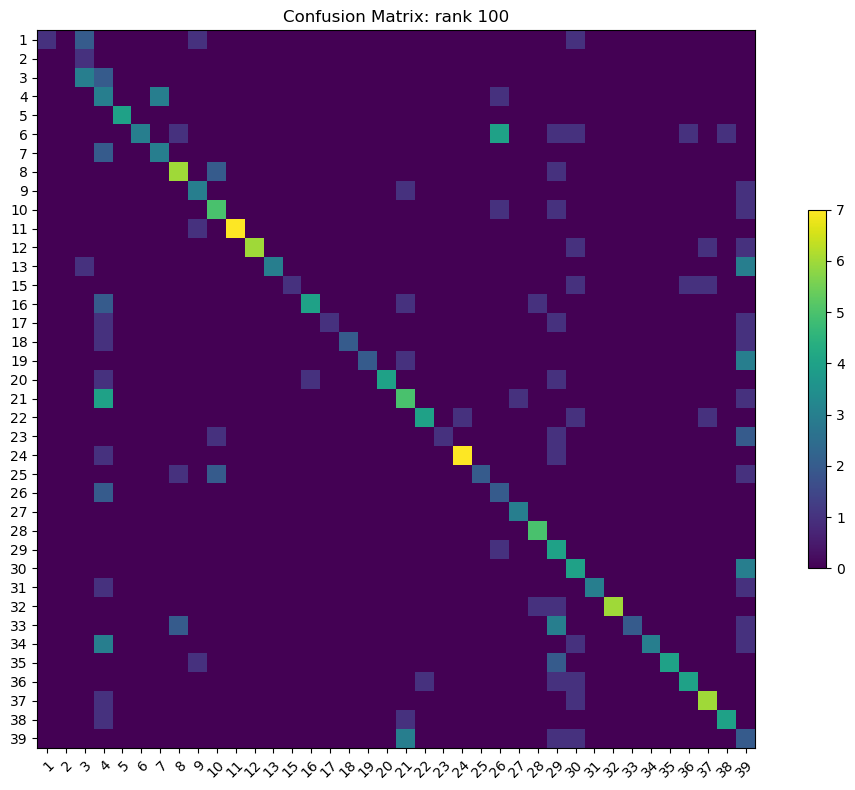

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


            Results   Average       Std
Accuracy   0.540984  0.588231  0.025296
Precision  0.754781  0.711801  0.018674
Recall     0.540984  0.588231  0.025296
F1         0.574124  0.608171  0.021274



Linear Discriminant Analysis Classifier



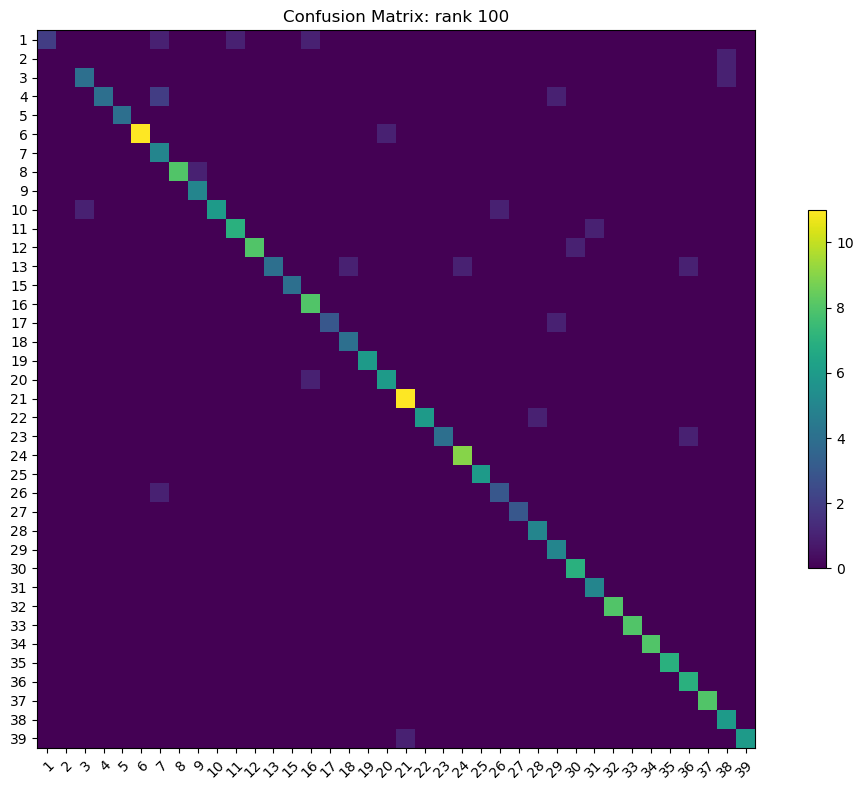

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


            Results   Average       Std
Accuracy   0.905738  0.905859  0.008627
Precision  0.920910  0.924838  0.008044
Recall     0.905738  0.905859  0.008627
F1         0.901648  0.907671  0.009169



Support Vector Machine Classifier



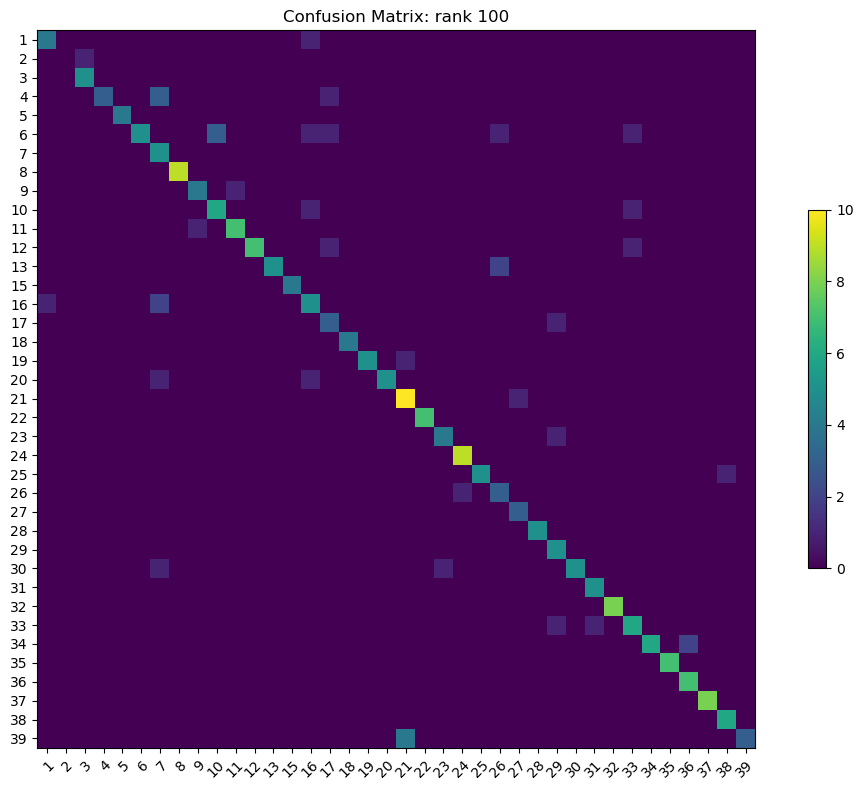

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


            Results   Average       Std
Accuracy   0.827869  0.840502  0.017278
Precision  0.868539  0.872261  0.014513
Recall     0.827869  0.840502  0.017278
F1         0.825824  0.841800  0.017390



Decision Tree Classifier



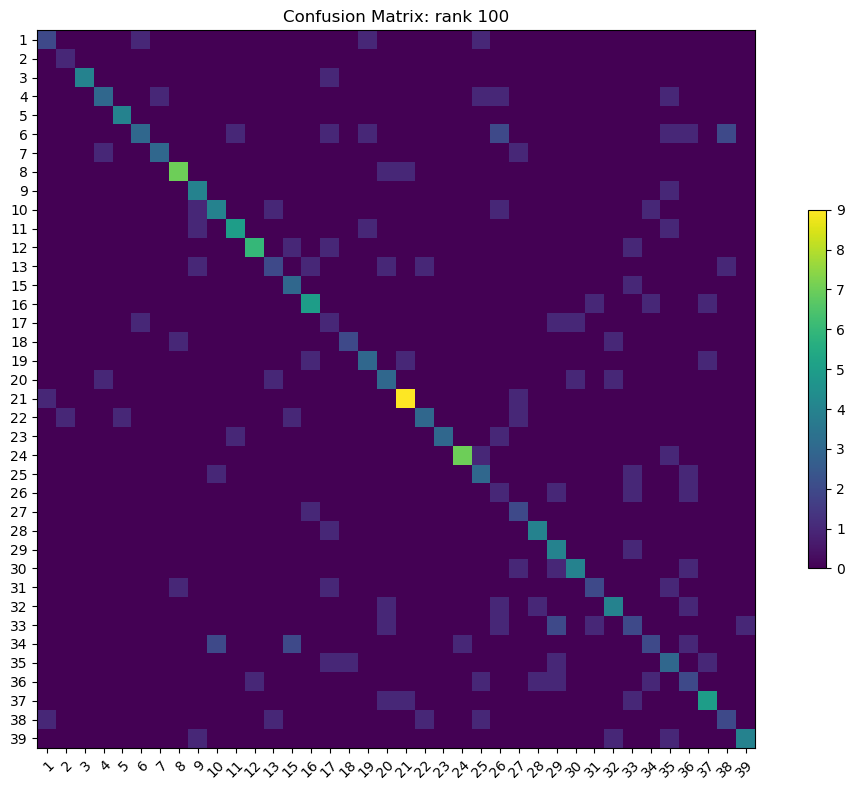

            Results   Average       Std
Accuracy   0.536885  0.531529  0.025553
Precision  0.574762  0.561601  0.019678
Recall     0.536885  0.531529  0.025553
F1         0.541536  0.531451  0.021723


'\n#ENTROPY VISUALIZATION\ndot_data = StringIO()\nexport_graphviz(model, out_file=dot_data,  \n                filled=True, rounded=True,\n                special_characters=True,\n               feature_names = X.columns)\n\ngraph = pydotplus.graph_from_dot_data(dot_data.getvalue())  \nImage(graph.create_png())\n'

In [138]:
#f.savefig("foo.pdf", bbox_inches='tight')
cv_folds = 5#number of cross validation folds
kf = KFold(n_splits = cv_folds, random_state = 17, shuffle = True)#initialize KFold for iterative cross validation 
for i in range(len(ranks)):#train classifiers on all low rank approximations
    #get train/test split data for specific low rank reconstruction
    X_train = split_mats['X_train_' + str(ranks[i])]
    X_test = split_mats['X_test_' + str(ranks[i])]
    y_train = split_mats['y_train_' + str(ranks[i])]
    y_test = split_mats['y_test_' + str(ranks[i])]
    
    #dictionaries to hold the classifier prediction scores for each cv fold
    aScore_cv = {'knn': [], 'nbc': [], 'lda': [], 'svc': [], 'dtree': []}
    P_cv = {'knn': [], 'nbc': [], 'lda': [], 'svc': [], 'dtree': []}
    R_cv = {'knn': [], 'nbc': [], 'lda': [], 'svc': [], 'dtree': []}
    F1_cv = {'knn': [], 'nbc': [], 'lda': [], 'svc': [], 'dtree': []}
    jj = 0#tracks cv fold iteration
    for train_index, test_index in kf.split(X_train):
        print("Progress {:2.1%}".format(jj / cv_folds), end="\r")#print progress
        #KNN
        k = 5 # number of neighbors
        distance_metric = 'euclidean'
        #set up model
        knn = KNeighborsClassifier(n_neighbors=k, metric=distance_metric)#initialize the model
        knn.fit(X_train[train_index,:], y_train[train_index])#train the model
        preds = knn.predict(X_train[test_index, :])
        aScore_cv['knn'].append(accuracy_score(y_train[test_index], preds)) 
        P_cv['knn'].append(precision_score(y_train[test_index], preds, average='weighted')) 
        R_cv['knn'].append(recall_score(y_train[test_index], preds, average='weighted')) 
        F1_cv['knn'].append(f1_score(y_train[test_index], preds, average='weighted'))
        
        #Naive Bayes
        nbc = GaussianNB() # default parameters
        nbc.fit(X_train[train_index,:], y_train[train_index])#training the model
        preds = nbc.predict(X_train[test_index, :])
        aScore_cv['nbc'].append(accuracy_score(y_train[test_index], preds)) 
        P_cv['nbc'].append(precision_score(y_train[test_index], preds, average='weighted')) 
        R_cv['nbc'].append(recall_score(y_train[test_index], preds, average='weighted')) 
        F1_cv['nbc'].append(f1_score(y_train[test_index], preds, average='weighted'))

        #Linear Discriminant Analysis (LDA)
        lda = LinearDiscriminantAnalysis(tol=0.01)#initialize the model
        lda.fit(X_train[train_index,:], y_train[train_index])#train model
        preds = lda.predict(X_train[test_index, :])
        aScore_cv['lda'].append(accuracy_score(y_train[test_index], preds)) 
        P_cv['lda'].append(precision_score(y_train[test_index], preds, average='weighted')) 
        R_cv['lda'].append(recall_score(y_train[test_index], preds, average='weighted')) 
        F1_cv['lda'].append(f1_score(y_train[test_index], preds, average='weighted'))

        #Support Vector Machine
        t = 0.001 # tolerance parameter
        kp = 'rbf' # kernel parameter
        probability=True
        svc = SVC(kernel=kp, tol=t, probability=probability)#initialize the model
        svc.fit(X_train[train_index,:], y_train[train_index])#train model
        preds = svc.predict(X_train[test_index, :])
        aScore_cv['svc'].append(accuracy_score(y_train[test_index], preds)) 
        P_cv['svc'].append(precision_score(y_train[test_index], preds, average='weighted')) 
        R_cv['svc'].append(recall_score(y_train[test_index], preds, average='weighted')) 
        F1_cv['svc'].append(f1_score(y_train[test_index], preds, average='weighted'))
        
        #Classification Tree
        dtree = DecisionTreeClassifier()#initialize the model, default parameters
        dtree.fit(X_train[train_index,:], y_train[train_index])#train model
        preds = dtree.predict(X_train[test_index, :])
        aScore_cv['dtree'].append(accuracy_score(y_train[test_index], preds)) 
        P_cv['dtree'].append(precision_score(y_train[test_index], preds, average='weighted')) 
        R_cv['dtree'].append(recall_score(y_train[test_index], preds, average='weighted')) 
        F1_cv['dtree'].append(f1_score(y_train[test_index], preds, average='weighted'))
        
        jj = jj + 1
    
    # KNN, K Nearest Neighbors, classifier (supervised)
    print ('\n\n\nK Nearest Neighbors Classifier\n')
    preds_knn = knn.predict(X_test)
    #calculate standard deviation of cross validation scores
    aScore_std = np.std(aScore_cv['knn'])
    P_std = np.std(P_cv['knn'])
    R_std = np.std(R_cv['knn'])
    F1_std = np.std(F1_cv['knn'])
    #calculate average scores across cross validation folds
    aScore_av = np.mean(aScore_cv['knn'])
    P_av = np.mean(P_cv['knn'])
    R_av = np.mean(R_cv['knn'])
    F1_av = np.mean(F1_cv['knn'])

    aScore = accuracy_score(y_test, preds_knn)#accuracy score on test data
    CM = confusion_matrix(y_test, preds_knn)# Confusion Matrix on test data
    cm_heatmap(CM, classes, title=': rank ' +str(ranks[i]))#plot of the multiclass confusion matrix
    P = precision_score(y_test, preds_knn, average='weighted')#precision score on test data
    R = recall_score(y_test, preds_knn, average='weighted')#recall score on test data
    F1 = f1_score(y_test, preds_knn, average='weighted')#F1 score on test data
    a = {'Results': [aScore, P, R, F1], 'Average': [aScore_av, P_av, R_av, F1_av], 'Std': [aScore_std, P_std, R_std, F1_std]}#series of evaluation results
    aFrame_k = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])

    print(aFrame_k)

    #Naive Bayes (supervised)
    print ('\n\n\nNaive Bayes Classifier\n')
    preds_nbc = nbc.predict(X_test)
    #calculate average scores across cross validation folds
    aScore_std = np.std(aScore_cv['nbc'])
    P_std = np.std(P_cv['nbc'])
    R_std = np.std(R_cv['nbc'])
    F1_std = np.std(F1_cv['nbc'])
    #calculate standard deviation of cross validation scores
    aScore_av = np.mean(aScore_cv['nbc'])
    P_av = np.mean(P_cv['nbc'])
    R_av = np.mean(R_cv['nbc'])
    F1_av = np.mean(F1_cv['nbc'])

    aScore = accuracy_score(y_test, preds_nbc)#get accuracy score on test data
    CM = confusion_matrix(y_test, preds_nbc)#Confusion Matrix on test data
    cm_heatmap(CM, classes, title=': rank ' +str(ranks[i]))#plot of the multiclass confusion matrix
    P = precision_score(y_test, preds_nbc, average='weighted')#precision score on test data
    R = recall_score(y_test, preds_nbc, average='weighted')#Recall score on test data
    F1 = f1_score(y_test, preds_nbc, average='weighted')#F1 score on test data
    a = {'Results': [aScore, P, R, F1], 'Average': [aScore_av, P_av, R_av, F1_av], 'Std': [aScore_std, P_std, R_std, F1_std]}#series of evaluation results
    aFrame_nbc = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])

    print(aFrame_nbc)#print evaluation results

    #Linear Discriminant Analysis (LDA)
    print ('\n\n\nLinear Discriminant Analysis Classifier\n')
    preds_lda = lda.predict(X_test)
    #calculate average scores across cross validation folds
    aScore_std = np.std(aScore_cv['lda'])
    P_std = np.std(P_cv['lda'])
    R_std = np.std(R_cv['lda'])
    F1_std = np.std(F1_cv['lda'])
    #calculate standard deviation of cross validation scores
    aScore_av = np.mean(aScore_cv['lda'])
    P_av = np.mean(P_cv['lda'])
    R_av = np.mean(R_cv['lda'])
    F1_av = np.mean(F1_cv['lda'])

    aScore = accuracy_score(y_test, preds_lda)#get accuracy score on test data
    CM = confusion_matrix(y_test, preds_lda)#create confusion matrix on test data
    cm_heatmap(CM, classes, title=': rank ' +str(ranks[i]))#plot of the multiclass confusion matrix
    P = precision_score(y_test, preds_lda, average='weighted')#get precision on test data
    R = recall_score(y_test, preds_lda, average='weighted')#get recall on test data
    F1 = f1_score(y_test, preds_lda, average='weighted')#get F1 score on test data
    a = {'Results': [aScore, P, R, F1], 'Average': [aScore_av, P_av, R_av, F1_av], 'Std': [aScore_std, P_std, R_std, F1_std]}#series of evaluation results
    aFrame_lda = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])

    print(aFrame_lda)#print series of evaluation metrics

    #Support Vector Machines (SVM)
    print ('\n\n\nSupport Vector Machine Classifier\n')
    preds_svc = svc.predict(X_test)
    #calculate average scores across cross validation folds
    aScore_std = np.std(aScore_cv['svc'])
    P_std = np.std(P_cv['svc'])
    R_std = np.std(R_cv['svc'])
    F1_std = np.std(F1_cv['svc'])
    #calculate standard deviation of cross validation scores
    aScore_av = np.mean(aScore_cv['svc'])
    P_av = np.mean(P_cv['svc'])
    R_av = np.mean(R_cv['svc'])
    F1_av = np.mean(F1_cv['svc'])

    aScore = accuracy_score(y_test, preds_svc)#accuracy score
    CM = confusion_matrix(y_test, preds_svc)# Confusion Matrix
    cm_heatmap(CM, classes, title=': rank ' +str(ranks[i]))#plot of the multiclass confusion matrix
    P = precision_score(y_test, preds_svc, average='weighted')#precision score
    R = recall_score(y_test, preds_svc, average='weighted')#recall score
    F1 = f1_score(y_test, preds_svc, average='weighted')#F1 score
    a = {'Results': [aScore, P, R, F1], 'Average': [aScore_av, P_av, R_av, F1_av], 'Std': [aScore_std, P_std, R_std, F1_std]}#series of evaluation results
    aFrame_svm = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])

    print(aFrame_svm)#print series of evaluation metrics

    #Classification Tree (look back at data science classification tree implementations)
    print ('\n\n\nDecision Tree Classifier\n')
    preds_dtree = dtree.predict(X_test)
    #calculate average scores across cross validation folds
    aScore_std = np.std(aScore_cv['dtree'])
    P_std = np.std(P_cv['dtree'])
    R_std = np.std(R_cv['dtree'])
    F1_std = np.std(F1_cv['dtree'])
    #calculate standard deviation of cross validation scores
    aScore_av = np.mean(aScore_cv['dtree'])
    P_av = np.mean(P_cv['dtree'])
    R_av = np.mean(R_cv['dtree'])
    F1_av = np.mean(F1_cv['dtree'])

    aScore = accuracy_score(y_test, preds_dtree)#accuracy score on test data
    CM = confusion_matrix(y_test, preds_dtree)# Confusion Matrix on test data
    cm_heatmap(CM, classes, title=': rank ' +str(ranks[i]))#plot of the multiclass confusion matrix
    P = precision_score(y_test, preds_dtree, average='weighted')#precision score on test data
    R = recall_score(y_test, preds_dtree, average='weighted')#recall score on test data
    F1 = f1_score(y_test, preds_dtree, average='weighted')#F1 score on test data
    a = {'Results': [aScore, P, R, F1], 'Average': [aScore_av, P_av, R_av, F1_av], 'Std': [aScore_std, P_std, R_std, F1_std]}#series of evaluation results
    aFrame_dtree = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
    print(aFrame_dtree)#print series of evaluation metrics
'''
#ENTROPY VISUALIZATION
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
               feature_names = X.columns)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
'''

In [52]:
#Gender classification
#train test split
ranks = [10, 50, 100]#ranks of data matrix to build classifiers for
data_mats = {}#dictionary to hold data matrices of different ranks
split_mats = {}#dictionary to hold train and test splits of various data matrices
y_ids_ints = np.array(gender_class)#individual face ids for classification

classes = np.unique(y_ids_ints)#list of unique face ids

for r in ranks:
    X_r = U[:, :r] @ np.diag(Sigma[:r]) @ VT[:r, :]#get low rank approximations of data matrix
    data_mats[str(r)] = X_r
    #Need to up sample minority female gender class to resolve class imbalance problem
    f_ind = np.where(y_ids_ints == 1)[0]#find where the female labels are in B for digit of interest
    m_ind = np.where(y_ids_ints == 0)[0]#find where the male labels are in B for digit of interest
    upsampled_y = resample(y_ids_ints[f_ind], replace=True,n_samples=len(m_ind),random_state=123)#upsample the true labels
    upsampled_X = resample(np.transpose(X_r[:, f_ind]), replace=True,n_samples=len(m_ind),random_state=123)#upsample the corresponding data for these labels in A
    y_ids_ints_up = np.append(y_ids_ints[m_ind], upsampled_y, axis=0)#create new training label set with upsample instances
    X_r_up = np.append(np.transpose(X_r[:, m_ind]), upsampled_X, axis=0)#create new training data set with upsample instances

    X_train, X_test, y_train, y_test = train_test_split(X_r_up, y_ids_ints_up, test_size = 0.1, random_state=1)
    split_mats['X_train_' + str(r)] = X_train
    split_mats['X_test_' + str(r)] = X_test
    split_mats['y_train_' + str(r)] = y_train
    split_mats['y_test_' + str(r)] = y_test
    

Progress 80.0%


K Nearest Neighbors Classifier



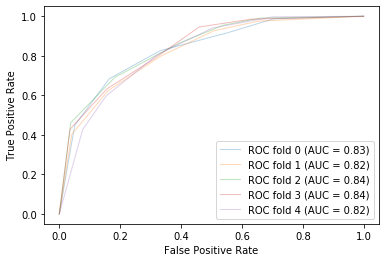

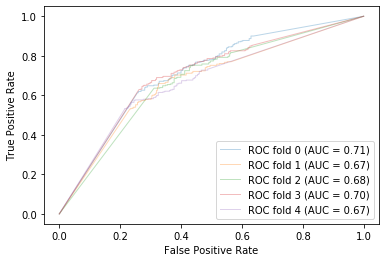

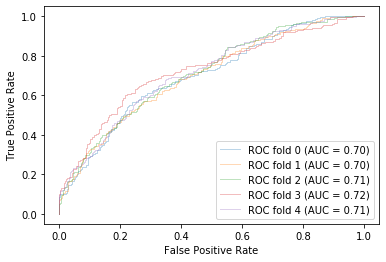

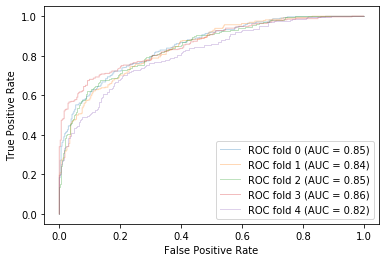

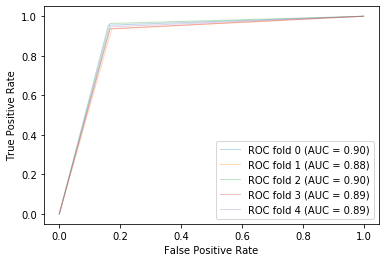

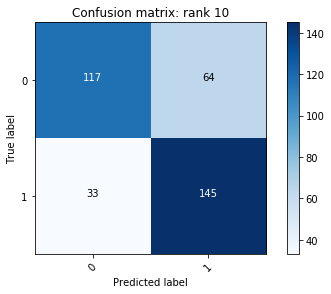

            Results   Average       Std
Accuracy   0.729805  0.738605  0.003747
Precision  0.737250  0.745347  0.006850
Recall     0.729805  0.738605  0.003747
F1         0.727974  0.736857  0.004458



Naive Bayes Classifier



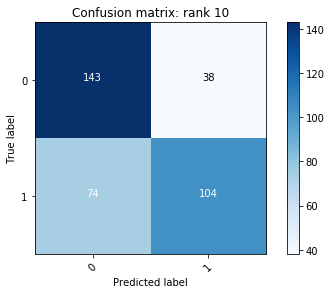

            Results   Average       Std
Accuracy   0.688022  0.663876  0.013846
Precision  0.695384  0.667692  0.012356
Recall     0.688022  0.663876  0.013846
F1         0.684583  0.661917  0.015000



Linear Discriminant Analysis Classifier



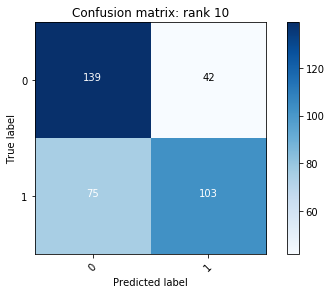

            Results   Average       Std
Accuracy   0.674095  0.657054  0.019150
Precision  0.679685  0.661052  0.017997
Recall     0.674095  0.657054  0.019150
F1         0.671060  0.654883  0.020203



Support Vector Machine Classifier



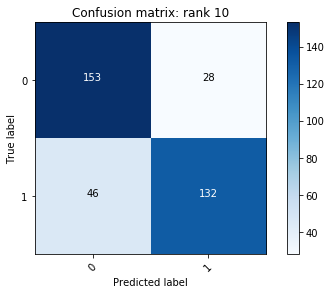

            Results   Average       Std
Accuracy   0.793872  0.757209  0.016070
Precision  0.796687  0.763715  0.016141
Recall     0.793872  0.757209  0.016070
F1         0.793265  0.755761  0.016613



Decision Tree Classifier



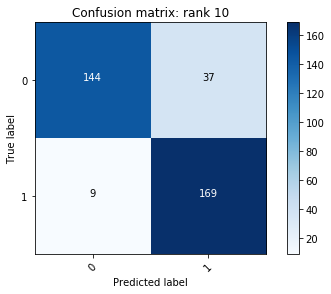

            Results   Average       Std
Accuracy   0.871866  0.890233  0.005997
Precision  0.881287  0.895453  0.007073
Recall     0.871866  0.890233  0.005997
F1         0.871167  0.889875  0.006000
Progress 80.0%


K Nearest Neighbors Classifier



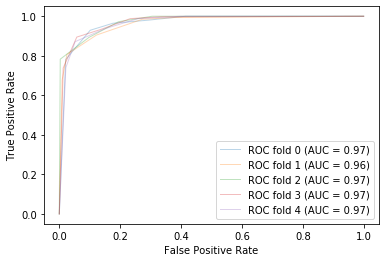

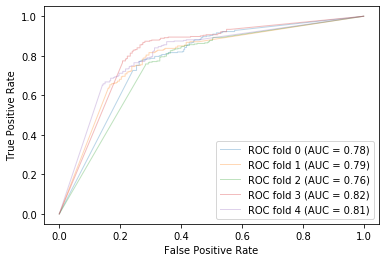

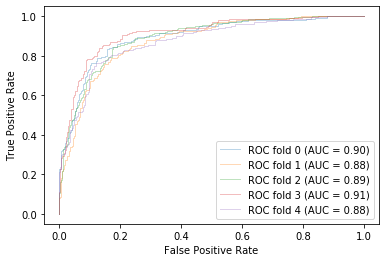

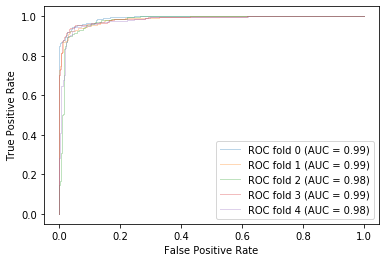

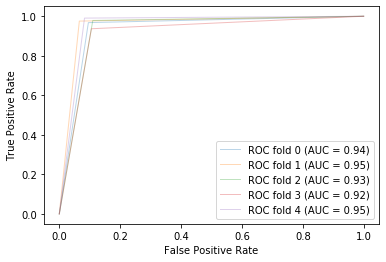

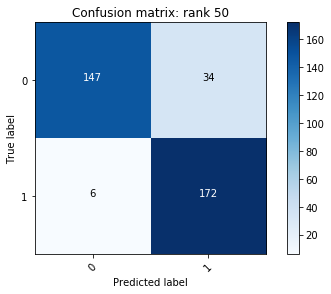

            Results   Average       Std
Accuracy   0.888579  0.893023  0.003252
Precision  0.898394  0.898035  0.003604
Recall     0.888579  0.893023  0.003252
F1         0.887971  0.892710  0.003383



Naive Bayes Classifier



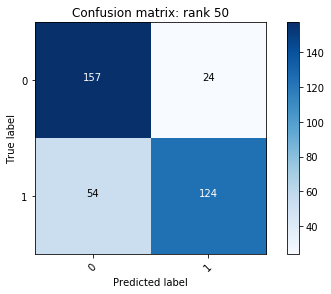

            Results   Average       Std
Accuracy   0.782730  0.750078  0.017359
Precision  0.790565  0.754240  0.017052
Recall     0.782730  0.750078  0.017359
F1         0.781047  0.749054  0.017657



Linear Discriminant Analysis Classifier



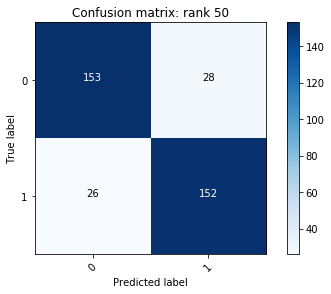

            Results   Average       Std
Accuracy   0.849582  0.826357  0.015962
Precision  0.849640  0.826930  0.015642
Recall     0.849582  0.826357  0.015962
F1         0.849585  0.826286  0.015986



Support Vector Machine Classifier



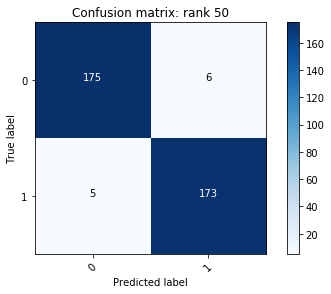

            Results   Average       Std
Accuracy   0.969359  0.940775  0.007030
Precision  0.969375  0.941215  0.006904
Recall     0.969359  0.940775  0.007030
F1         0.969360  0.940764  0.007042



Decision Tree Classifier



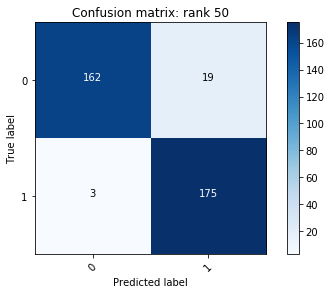

            Results   Average       Std
Accuracy   0.938719  0.938915  0.014264
Precision  0.942273  0.940754  0.014526
Recall     0.938719  0.938915  0.014264
F1         0.938620  0.938854  0.014280
Progress 80.0%


K Nearest Neighbors Classifier



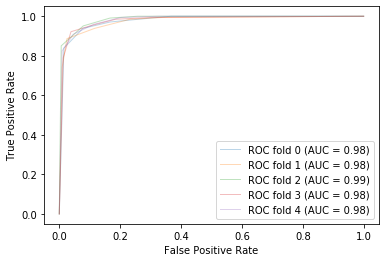

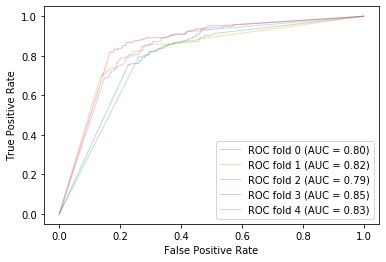

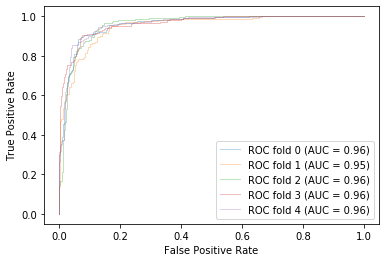

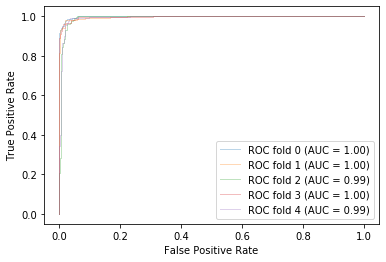

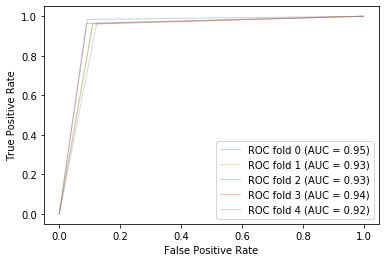

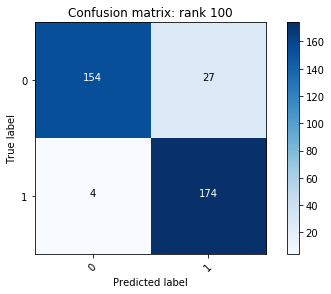

            Results   Average       Std
Accuracy   0.913649  0.914419  0.009271
Precision  0.920633  0.919146  0.007227
Recall     0.913649  0.914419  0.009271
F1         0.913340  0.914192  0.009340



Naive Bayes Classifier



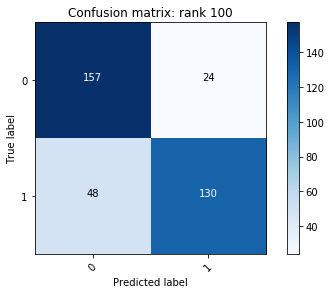

            Results   Average       Std
Accuracy   0.799443  0.779225  0.022820
Precision  0.804678  0.782622  0.022004
Recall     0.799443  0.779225  0.022820
F1         0.798429  0.778497  0.023146



Linear Discriminant Analysis Classifier



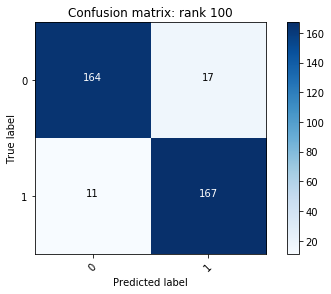

            Results   Average       Std
Accuracy   0.922006  0.897984  0.012065
Precision  0.922499  0.898462  0.012208
Recall     0.922006  0.897984  0.012065
F1         0.921995  0.897970  0.012060



Support Vector Machine Classifier



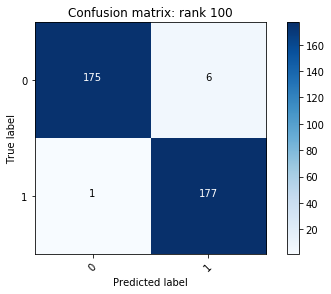

            Results   Average       Std
Accuracy   0.980501  0.971783  0.003721
Precision  0.980879  0.971991  0.003794
Recall     0.980501  0.971783  0.003721
F1         0.980500  0.971780  0.003724



Decision Tree Classifier



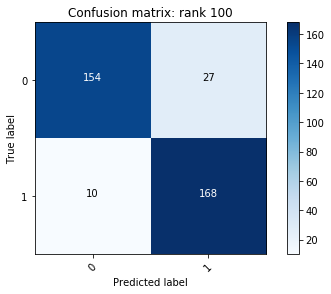

            Results   Average       Std
Accuracy   0.896936  0.930853  0.008965
Precision  0.900605  0.933127  0.008836
Recall     0.896936  0.930853  0.008965
F1         0.896745  0.930764  0.009005


In [53]:
#Gender classification
cv_folds = 5#number of cross validation folds
kf = KFold(n_splits = cv_folds, random_state = 17, shuffle = True)#initialize KFold for iterative cross validation 
for i in range(len(ranks)):#train classifiers on all low rank approximations
    #get train/test split data for specific low rank reconstruction
    X_train = split_mats['X_train_' + str(ranks[i])]
    X_test = split_mats['X_test_' + str(ranks[i])]
    y_train = split_mats['y_train_' + str(ranks[i])]
    y_test = split_mats['y_test_' + str(ranks[i])]
    
    #dictionaries to hold the classifier prediction scores for each cv fold
    aScore_cv = {'knn': [], 'nbc': [], 'lda': [], 'svc': [], 'dtree': []}
    P_cv = {'knn': [], 'nbc': [], 'lda': [], 'svc': [], 'dtree': []}
    R_cv = {'knn': [], 'nbc': [], 'lda': [], 'svc': [], 'dtree': []}
    F1_cv = {'knn': [], 'nbc': [], 'lda': [], 'svc': [], 'dtree': []}
    tprs = {'knn': [], 'nbc': [], 'lda': [], 'svc': [], 'dtree': []}
    aucs = {'knn': [], 'nbc': [], 'lda': [], 'svc': [], 'dtree': []}
    mean_fpr = np.linspace(0, 1, 100)
    #initialize figures and axes for ROC curve plotting
    fig_knn, ax_knn = plt.subplots()#knn ROC curve
    fig_nbc, ax_nbc = plt.subplots()#nbcROC curve
    fig_lda, ax_lda = plt.subplots()#lda ROC curve
    fig_svc, ax_svc = plt.subplots()#svc ROC curve
    fig_dtree, ax_dtree = plt.subplots()#dtree ROC curve
    
    jj = 0#tracks cv fold iteration
    for train_index, test_index in kf.split(X_train):
        print("Progress {:2.1%}".format(jj / cv_folds), end="\r")#print progress
        #KNN
        k = 5 # number of neighbors
        distance_metric = 'euclidean'
        #set up model
        knn = KNeighborsClassifier(n_neighbors=k, metric=distance_metric)#initialize the model
        knn.fit(X_train[train_index,:], y_train[train_index])#train the model
        preds = knn.predict(X_train[test_index, :])
        aScore_cv['knn'].append(accuracy_score(y_train[test_index], preds)) 
        P_cv['knn'].append(precision_score(y_train[test_index], preds, average='weighted')) 
        R_cv['knn'].append(recall_score(y_train[test_index], preds, average='weighted')) 
        F1_cv['knn'].append(f1_score(y_train[test_index], preds, average='weighted'))
        #Compute ROC values for plotting
        viz = plot_roc_curve(knn, X_train[test_index, :], y_train[test_index],
                         name='ROC fold {}'.format(jj),
                         alpha=0.3, lw=1, ax=ax_knn)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs['knn'].append(interp_tpr)
        aucs['knn'].append(viz.roc_auc)
        
        #Naive Bayes
        nbc = GaussianNB() # default parameters
        nbc.fit(X_train[train_index,:], y_train[train_index])#training the model
        preds = nbc.predict(X_train[test_index, :])
        aScore_cv['nbc'].append(accuracy_score(y_train[test_index], preds)) 
        P_cv['nbc'].append(precision_score(y_train[test_index], preds, average='weighted')) 
        R_cv['nbc'].append(recall_score(y_train[test_index], preds, average='weighted')) 
        F1_cv['nbc'].append(f1_score(y_train[test_index], preds, average='weighted'))
        #Compute ROC values for plotting
        viz = plot_roc_curve(nbc, X_train[test_index, :], y_train[test_index],
                         name='ROC fold {}'.format(jj),
                         alpha=0.3, lw=1, ax=ax_nbc)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs['nbc'].append(interp_tpr)
        aucs['nbc'].append(viz.roc_auc)

        #Linear Discriminant Analysis (LDA)
        lda = LinearDiscriminantAnalysis(tol=0.01)#initialize the model
        lda.fit(X_train[train_index,:], y_train[train_index])#train model
        preds = lda.predict(X_train[test_index, :])
        aScore_cv['lda'].append(accuracy_score(y_train[test_index], preds)) 
        P_cv['lda'].append(precision_score(y_train[test_index], preds, average='weighted')) 
        R_cv['lda'].append(recall_score(y_train[test_index], preds, average='weighted')) 
        F1_cv['lda'].append(f1_score(y_train[test_index], preds, average='weighted'))
        #Compute ROC values for plotting
        viz = plot_roc_curve(lda, X_train[test_index, :], y_train[test_index],
                         name='ROC fold {}'.format(jj),
                         alpha=0.3, lw=1, ax=ax_lda)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs['lda'].append(interp_tpr)
        aucs['lda'].append(viz.roc_auc)

        #Support Vector Machine
        t = 0.001 # tolerance parameter
        kp = 'rbf' # kernel parameter
        probability=True
        svc = SVC(kernel=kp, tol=t, probability=probability)#initialize the model
        svc.fit(X_train[train_index,:], y_train[train_index])#train model
        preds = svc.predict(X_train[test_index, :])
        aScore_cv['svc'].append(accuracy_score(y_train[test_index], preds)) 
        P_cv['svc'].append(precision_score(y_train[test_index], preds, average='weighted')) 
        R_cv['svc'].append(recall_score(y_train[test_index], preds, average='weighted')) 
        F1_cv['svc'].append(f1_score(y_train[test_index], preds, average='weighted'))
        #Compute ROC values for plotting
        viz = plot_roc_curve(svc, X_train[test_index, :], y_train[test_index],
                         name='ROC fold {}'.format(jj),
                         alpha=0.3, lw=1, ax=ax_svc)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs['svc'].append(interp_tpr)
        aucs['svc'].append(viz.roc_auc)
        
        #Classification Tree
        dtree = DecisionTreeClassifier()#initialize the model, default parameters
        dtree.fit(X_train[train_index,:], y_train[train_index])#train model
        preds = dtree.predict(X_train[test_index, :])
        aScore_cv['dtree'].append(accuracy_score(y_train[test_index], preds)) 
        P_cv['dtree'].append(precision_score(y_train[test_index], preds, average='weighted')) 
        R_cv['dtree'].append(recall_score(y_train[test_index], preds, average='weighted')) 
        F1_cv['dtree'].append(f1_score(y_train[test_index], preds, average='weighted'))
        #Compute ROC values for plotting
        viz = plot_roc_curve(dtree, X_train[test_index, :], y_train[test_index],
                         name='ROC fold {}'.format(jj),
                         alpha=0.3, lw=1, ax=ax_dtree)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs['dtree'].append(interp_tpr)
        aucs['dtree'].append(viz.roc_auc)
        
        jj = jj + 1
    
    # KNN, K Nearest Neighbors, classifier (supervised)
    print ('\n\n\nK Nearest Neighbors Classifier\n')
    preds_knn = knn.predict(X_test)
    #calculate standard deviation of cross validation scores
    aScore_std = np.std(aScore_cv['knn'])
    P_std = np.std(P_cv['knn'])
    R_std = np.std(R_cv['knn'])
    F1_std = np.std(F1_cv['knn'])
    #calculate average scores across cross validation folds
    aScore_av = np.mean(aScore_cv['knn'])
    P_av = np.mean(P_cv['knn'])
    R_av = np.mean(R_cv['knn'])
    F1_av = np.mean(F1_cv['knn'])

    aScore = accuracy_score(y_test, preds_knn)#accuracy score on test data
    CM = confusion_matrix(y_test, preds_knn)# Confusion Matrix on test data
    plot_confusion_matrix(CM, classes, title='Confusion matrix: rank '+str(ranks[i]))#plot of the multiclass confusion matrix
    P = precision_score(y_test, preds_knn, average='weighted')#precision score on test data
    R = recall_score(y_test, preds_knn, average='weighted')#recall score on test data
    F1 = f1_score(y_test, preds_knn, average='weighted')#F1 score on test data
    a = {'Results': [aScore, P, R, F1], 'Average': [aScore_av, P_av, R_av, F1_av], 'Std': [aScore_std, P_std, R_std, F1_std]}#series of evaluation results
    aFrame_k = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
    #Plot ROC curves
    ax_knn.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs['knn'], axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs['knn'])
    ax_knn.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs['knn'], axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax_knn.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax_knn.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="K-Nearest Neighbors Classifier ROC Curve, rank " +str(ranks[i]))
    ax_knn.legend(loc="lower right")

    print(aFrame_k)

    #Naive Bayes (supervised)
    print ('\n\n\nNaive Bayes Classifier\n')
    preds_nbc = nbc.predict(X_test)
    #calculate average scores across cross validation folds
    aScore_std = np.std(aScore_cv['nbc'])
    P_std = np.std(P_cv['nbc'])
    R_std = np.std(R_cv['nbc'])
    F1_std = np.std(F1_cv['nbc'])
    #calculate standard deviation of cross validation scores
    aScore_av = np.mean(aScore_cv['nbc'])
    P_av = np.mean(P_cv['nbc'])
    R_av = np.mean(R_cv['nbc'])
    F1_av = np.mean(F1_cv['nbc'])

    aScore = accuracy_score(y_test, preds_nbc)#get accuracy score on test data
    CM = confusion_matrix(y_test, preds_nbc)#Confusion Matrix on test data
    plot_confusion_matrix(CM, classes, title='Confusion matrix: rank '+str(ranks[i]))#plot of the multiclass confusion matrix
    P = precision_score(y_test, preds_nbc, average='weighted')#precision score on test data
    R = recall_score(y_test, preds_nbc, average='weighted')#Recall score on test data
    F1 = f1_score(y_test, preds_nbc, average='weighted')#F1 score on test data
    a = {'Results': [aScore, P, R, F1], 'Average': [aScore_av, P_av, R_av, F1_av], 'Std': [aScore_std, P_std, R_std, F1_std]}#series of evaluation results
    aFrame_nbc = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
    #Plot ROC curves
    ax_nbc.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs['nbc'], axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs['nbc'])
    ax_nbc.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs['nbc'], axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax_nbc.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax_nbc.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Naive Bayes Classifier ROC Curve, rank " +str(ranks[i]))
    ax_nbc.legend(loc="lower right")

    print(aFrame_nbc)#print evaluation results

    #Linear Discriminant Analysis (LDA)
    print ('\n\n\nLinear Discriminant Analysis Classifier\n')
    preds_lda = lda.predict(X_test)
    #calculate average scores across cross validation folds
    aScore_std = np.std(aScore_cv['lda'])
    P_std = np.std(P_cv['lda'])
    R_std = np.std(R_cv['lda'])
    F1_std = np.std(F1_cv['lda'])
    #calculate standard deviation of cross validation scores
    aScore_av = np.mean(aScore_cv['lda'])
    P_av = np.mean(P_cv['lda'])
    R_av = np.mean(R_cv['lda'])
    F1_av = np.mean(F1_cv['lda'])

    aScore = accuracy_score(y_test, preds_lda)#get accuracy score on test data
    CM = confusion_matrix(y_test, preds_lda)#create confusion matrix on test data
    plot_confusion_matrix(CM, classes, title='Confusion matrix: rank '+str(ranks[i]))#plot of the multiclass confusion matrix
    P = precision_score(y_test, preds_lda, average='weighted')#get precision on test data
    R = recall_score(y_test, preds_lda, average='weighted')#get recall on test data
    F1 = f1_score(y_test, preds_lda, average='weighted')#get F1 score on test data
    a = {'Results': [aScore, P, R, F1], 'Average': [aScore_av, P_av, R_av, F1_av], 'Std': [aScore_std, P_std, R_std, F1_std]}#series of evaluation results
    aFrame_lda = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
    #Plot ROC curves
    ax_lda.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs['lda'], axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs['lda'])
    ax_lda.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs['lda'], axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax_lda.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax_lda.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Linear Discriminant Analysis Classifier ROC Curve, rank " +str(ranks[i]))
    ax_lda.legend(loc="lower right")

    print(aFrame_lda)#print series of evaluation metrics

    #Support Vector Machines (SVM)
    print ('\n\n\nSupport Vector Machine Classifier\n')
    preds_svc = svc.predict(X_test)
    #calculate average scores across cross validation folds
    aScore_std = np.std(aScore_cv['svc'])
    P_std = np.std(P_cv['svc'])
    R_std = np.std(R_cv['svc'])
    F1_std = np.std(F1_cv['svc'])
    #calculate standard deviation of cross validation scores
    aScore_av = np.mean(aScore_cv['svc'])
    P_av = np.mean(P_cv['svc'])
    R_av = np.mean(R_cv['svc'])
    F1_av = np.mean(F1_cv['svc'])

    aScore = accuracy_score(y_test, preds_svc)#accuracy score
    CM = confusion_matrix(y_test, preds_svc)# Confusion Matrix
    plot_confusion_matrix(CM, classes, title='Confusion matrix: rank '+str(ranks[i]))#plot of the multiclass confusion matrix
    P = precision_score(y_test, preds_svc, average='weighted')#precision score
    R = recall_score(y_test, preds_svc, average='weighted')#recall score
    F1 = f1_score(y_test, preds_svc, average='weighted')#F1 score
    a = {'Results': [aScore, P, R, F1], 'Average': [aScore_av, P_av, R_av, F1_av], 'Std': [aScore_std, P_std, R_std, F1_std]}#series of evaluation results
    aFrame_svm = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
    #Plot ROC curves
    ax_svc.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs['svc'], axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs['svc'])
    ax_svc.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs['svc'], axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax_svc.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax_svc.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Support Vector Machine Classifier ROC Curve, rank " +str(ranks[i]))
    ax_svc.legend(loc="lower right")

    print(aFrame_svm)#print series of evaluation metrics

    #Classification Tree (look back at data science classification tree implementations)
    print ('\n\n\nDecision Tree Classifier\n')
    preds_dtree = dtree.predict(X_test)
    #calculate average scores across cross validation folds
    aScore_std = np.std(aScore_cv['dtree'])
    P_std = np.std(P_cv['dtree'])
    R_std = np.std(R_cv['dtree'])
    F1_std = np.std(F1_cv['dtree'])
    #calculate standard deviation of cross validation scores
    aScore_av = np.mean(aScore_cv['dtree'])
    P_av = np.mean(P_cv['dtree'])
    R_av = np.mean(R_cv['dtree'])
    F1_av = np.mean(F1_cv['dtree'])

    aScore = accuracy_score(y_test, preds_dtree)#accuracy score on test data
    CM = confusion_matrix(y_test, preds_dtree)# Confusion Matrix on test data
    plot_confusion_matrix(CM, classes, title='Confusion matrix: rank '+str(ranks[i]))#plot of the multiclass confusion matrix
    P = precision_score(y_test, preds_dtree, average='weighted')#precision score on test data
    R = recall_score(y_test, preds_dtree, average='weighted')#recall score on test data
    F1 = f1_score(y_test, preds_dtree, average='weighted')#F1 score on test data
    a = {'Results': [aScore, P, R, F1], 'Average': [aScore_av, P_av, R_av, F1_av], 'Std': [aScore_std, P_std, R_std, F1_std]}#series of evaluation results
    aFrame_dtree = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
    #Plot ROC curves
    ax_dtree.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs['dtree'], axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs['dtree'])
    ax_dtree.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs['dtree'], axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax_dtree.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax_dtree.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Decision Tree Classifier ROC Curve, rank " +str(ranks[i]))
    ax_dtree.legend(loc="lower right")
    
    print(aFrame_dtree)#print series of evaluation metrics
    
    fig_knn.savefig('knn_rank_'+str(ranks[i])+'.png')
    fig_nbc.savefig('nbc_rank_'+str(ranks[i])+'.png')
    fig_lda.savefig('lda_rank_'+str(ranks[i])+'.png')
    fig_svc.savefig('svc_rank_'+str(ranks[i])+'.png')
    fig_dtree.savefig('dtree_rank_'+str(ranks[i])+'.png')

                                    Results
Homogeneity                        0.001204
Completeness                       0.000444
V-measure                          0.000649
Adjusted Rand index (ARI)          0.001554
Adjusted Mutual Information (AMI) -0.000122
Silhouette                         0.189880


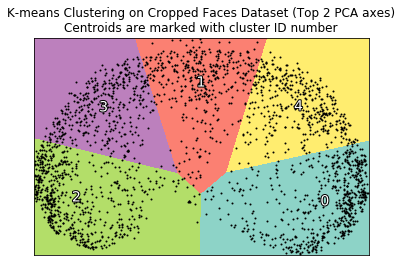

                                    Results
Homogeneity                        0.004888
Completeness                       0.001578
V-measure                          0.002385
Adjusted Rand index (ARI)          0.002744
Adjusted Mutual Information (AMI)  0.001514
Silhouette                         0.382625


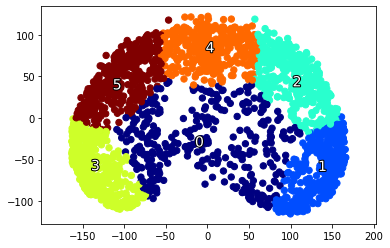

In [54]:
data = np.transpose(data_mats['100'])#transpose s.t. face image instances are along the row axis
n_samples, n_features = data.shape
n_ids = len(classes)
labels = y_ids_ints

sample_size = 300

Sum_of_squared_distances = []
K = range(2,15)
count = 0
for k in K:
    print("Progress {:2.1%}".format(count / len(K)), end="\r")#print progress
    km = KMeans(init='k-means++', n_clusters=k, n_init=10)
    km = km.fit(data)
    sil = metrics.silhouette_score(data, km.labels_, metric='euclidean', sample_size=sample_size)
    Sum_of_squared_distances.append(sil)
    count = count + 1
            
'''
#As k increases, the sum of squared distance tends to zero. Imagine we set k to its maximum value n (where n is number of samples) each sample will form its own cluster meaning sum of squared distances equals zero.
#Below is a plot of sum of squared distances for k in the range specified above. If the plot looks like an arm, then the elbow on the arm is optimal k.
'''
plt.plot(K, Sum_of_squared_distances, 'bo-')
plt.xlabel('number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Silhouette coefficient Method For Optimal Clusters, K-Means')
plt.show()

bics = []
aics = []
K = range(1,15)
count = 0
for k in K:
    print("Progress {:2.1%}".format(count / len(K)), end="\r")#print progress
    gmm = GMM(k, covariance_type='diag', random_state=0)
    bic = gmm.fit(data).bic(data)
    aic = gmm.fit(data).aic(data)
    bics.append(bic)
    aics.append(aic)
    count = count + 1

'''
#As k increases, the sum of squared distance tends to zero. Imagine we set k to its maximum value n (where n is number of samples) each sample will form its own cluster meaning sum of squared distances equals zero.
#Below is a plot of sum of squared distances for k in the range specified above. If the plot looks like an arm, then the elbow on the arm is optimal k.
'''
plt.plot(K, np.log(bics), 'bo-', label='BIC')
plt.plot(K, np.log(aics), 'ro-', label='AIC')
plt.legend(loc='best')
plt.xlabel('number of clusters')
plt.ylabel('Log Score')
plt.title('AIC/BIC Method For Optimal Clusters, GMM')
plt.show()



bench_cluster(KMeans(init='k-means++', n_clusters=5, n_init=10),
              name="k-means++", data=data)

# Visualize the results on PCA-reduced data
reduced_data = PCA(n_components=2).fit_transform(data)

kmeans = KMeans(init='k-means++', n_clusters=5, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Set3,#plt.get_cmap('hsv', 38),#plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white digit identifier
centroids = kmeans.cluster_centers_

for i in range(centroids.shape[0]):
    txt = plt.text(centroids[i, 0], centroids[i, 1], str(np.arange(centroids.shape[0])[i]), horizontalalignment='center',
        verticalalignment='center', color="white", fontsize=14)
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='black')])
plt.title('K-means Clustering on Cropped Faces Dataset (Top 2 PCA axes)\n'
          'Centroids are marked with cluster ID number')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

#Gaussian Mixtures (unsupervised)
gmm = GMM(n_components=6, random_state=42)
bench_cluster(gmm, name="GMM", data=reduced_data)#get performance statistics
plot_gmm(gmm, reduced_data, np.arange(0, 6))#visualize clusters in 2D